<a href="https://colab.research.google.com/github/vsvale/Data-Engineering-Foundations/blob/main/Data_Engineering_Foundations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseado na prática do curso Data Engineering Foundations (https://www.linkedin.com/learning/data-engineering-foundations).<br>
Tem como objetivo carregar dados de um dataset csv (https://www.kaggle.com/rounakbanik/the-movies-dataset) para um banco de dados, em seguida realizar operações ETL e gravar o dataframe spark resultante no banco.

In [1]:
#montar o google Drive para suportar os arquivos
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#criar pasta de trabalho
!mkdir "/content/gdrive/My Drive/Movie_DB"

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Movie_DB"

In [4]:
#Acessar a pasta de trabalho
%cd /content/gdrive/My Drive/Movie_DB

/content/gdrive/My Drive/Movie_DB


In [5]:
#Acessar https://www.kaggle.com/ a guia account no profile do seu usuario, crie um se não tiver,  e crie umanova chave de API. Suba o kaggle.json ele será necessário para baixar o dataset
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


# Buscando os dados

In [6]:
# Baixar do kaggle o Moviedb dataset
!kaggle datasets download -d rounakbanik/the-movies-dataset

 97% 222M/228M [00:03<00:00, 66.8MB/s]
100% 228M/228M [00:03<00:00, 70.7MB/s]


In [7]:
%ls

kaggle.json  the-movies-dataset.zip


In [8]:
#Descompactar o arquivo baixado e em seguida remover o zip
!unzip \*.zip  && rm *.zip

Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [9]:
#Remover arquivos desnecessários
!rm credits.csv && rm keywords.csv && rm links.csv && rm links_small.csv && rm ratings_small.csv

In [10]:
%ls

kaggle.json  movies_metadata.csv  ratings.csv


In [11]:
import pandas as pd

In [12]:
#csv para dataframe
movies = pd.read_csv('./movies_metadata.csv')
users = pd.read_csv('./ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Database Schema

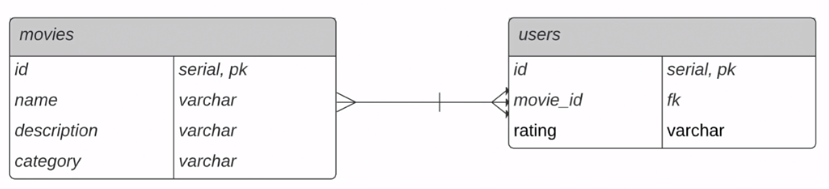

## Movies

In [13]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [14]:
#Selecionar as colunas que o banco de dados possui
movies = movies[['id','title','overview','genres']]
movies.head()

,id,title,overview,genres
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


In [15]:
#Renomear as colunas segundo o banco de dados
movies = movies.rename(columns={'title': 'name','overview':'description','genres':'category'})
movies.head()

,id,name,description,category
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


In [16]:
#Remover linhas que contenham nan
movies.dropna(inplace = True)

In [17]:
#verificar o tipo de dados de cada coluna
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44506 entries, 0 to 45465
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           44506 non-null  object
 1   name         44506 non-null  object
 2   description  44506 non-null  object
 3   category     44506 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [18]:
#alterar id para inteiro
movies['id'] = pd.to_numeric(movies['id'])
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44506 entries, 0 to 45465
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           44506 non-null  int64 
 1   name         44506 non-null  object
 2   description  44506 non-null  object
 3   category     44506 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [19]:
#como string posso dar um replace e tirar as partes do dicionario e montar uma lista, sim foi o modo força bruta
movies['category'] = movies['category'].str.replace("'id'", '')
movies['category'] = movies['category'].str.replace("'name'", '')
movies['category'] = movies['category'].str.replace("\d", '')
movies['category'] = movies['category'].str.replace(":", '')
movies['category'] = movies['category'].str.replace(pat = '{', repl = '')
movies['category'] = movies['category'].str.replace(pat = '}', repl = '')
movies['category'] = movies['category'].str.replace(pat = ' ', repl = '')
movies['category'] = movies['category'].str.replace(pat = ",'", repl = "'")
#avalia o formato como lista e aplica esse tipo
movies['category'] = movies['category'].apply(eval)

In [20]:
movies['category'].head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: category, dtype: object

In [21]:
movies.head()

,id,name,description,category
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]"
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]"
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[Romance, Comedy]"
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]"
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,[Comedy]


## Users

In [22]:
users.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [23]:
users = users[['userId','movieId','rating']]
users.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [24]:
users = users.rename(columns={'userId':'id','movieId':'movie_id'})
users.head()

,id,movie_id,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [25]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int64  
 1   movie_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 595.6 MB


# Criando o Database

In [26]:
#cria o db
import sqlite3
con = sqlite3.connect('MoviesDB.db')
cur = con.cursor()

In [27]:
#comando com a sql para criar a tabela MOVIES
create_movie = """CREATE TABLE IF NOT EXISTS """+"""MOVIES"""+"""(id INTEGER PRIMARY KEY,name TEXT NOT NULL, description TEXT, category TEXT)"""
create_movie

'CREATE TABLE IF NOT EXISTS MOVIES(id INTEGER PRIMARY KEY,name TEXT NOT NULL, description TEXT, category TEXT)'

In [28]:
#executa o comando de criação
cur.execute(create_movie)

In [29]:
create_users = """CREATE TABLE IF NOT EXISTS """+"""USERS"""+"""(id INTEGER,movie_id INTEGER NOT NULL,rating REAL,PRIMARY KEY(id,movie_id),FOREIGN KEY (movie_id) REFERENCES MOVIES (id) ON DELETE CASCADE ON UPDATE NO ACTION)"""
create_users

'CREATE TABLE IF NOT EXISTS USERS(id INTEGER,movie_id INTEGER NOT NULL,rating REAL,PRIMARY KEY(id,movie_id),FOREIGN KEY (movie_id) REFERENCES MOVIES (id) ON DELETE CASCADE ON UPDATE NO ACTION)'

In [30]:
cur.execute(create_users)
con.commit()

In [31]:
#Cria a primeira parte do comando de inserção na tabela
insert_movies = """INSERT INTO"""+""" MOVIES"""+"""("""+','.join(movies.columns)+""") VALUES ("""+','.join(map(str,'?'*len(movies.columns)))+""")"""
insert_movies

'INSERT INTO MOVIES(id,name,description,category) VALUES (?,?,?,?)'

In [32]:
insert_users = """INSERT INTO"""+""" USERS"""+"""("""+','.join(users.columns)+""") VALUES ("""+','.join(map(str,'?'*len(users.columns)))+""")"""
insert_users

'INSERT INTO USERS(id,movie_id,rating) VALUES (?,?,?)'

In [33]:
#ordernar o dataframe por id para melhorar a performance
movies.sort_values(by=['id'], inplace=True)
movies.head()

,id,name,description,category
4342,2,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,"[Drama, Crime]"
12947,3,Shadows in Paradise,"An episode in the life of Nikander, a garbage ...","[Drama, Comedy]"
17,5,Four Rooms,It's Ted the Bellhop's first night on the job....,"[Crime, Comedy]"
474,6,Judgment Night,"While racing to a boxing match, Frank, Mike, J...","[Action, Thriller, Crime]"
256,11,Star Wars,Princess Leia is captured and held hostage by ...,"[Adventure, Action, ScienceFiction]"


In [34]:
#dropar registros duplicados pelo id, já que o id é pk
movies.drop_duplicates(subset='id', keep=False,inplace=True)

In [35]:
#dataframe transformado em tipo string para completar o comando de insert
movies = movies.astype(str)

In [36]:
#percorre todas as linhas do dataframe, executando as duas partes do comando de insert
for i in range(len(movies)):
  insert = tuple(movies.iloc[i])
  cur.execute(insert_movies,insert)
con.commit()

In [37]:
users.sort_values(by=['id'], inplace=True)
users.head()

,id,movie_id,rating
0,1,110,1.0
26,1,112552,5.0
25,1,99114,4.0
24,1,98809,0.5
23,1,96821,5.0


In [38]:
users.drop_duplicates(subset=['id','movie_id'], keep=False,inplace=True)

In [39]:
users.head()

,id,movie_id,rating
0,1,110,1.0
26,1,112552,5.0
25,1,99114,4.0
24,1,98809,0.5
23,1,96821,5.0


In [40]:
for i in range(len(users)):
  insert = tuple(users.iloc[i])
  cur.execute(insert_users,insert)
con.commit()

In [41]:
#fechar a conexão com o banco
con.close()

In [42]:
#deletar dataframes e remover arquivos desnecessários
del movies
del users
!rm ./ratings.csv  && rm ./movies_metadata.csv

# Pandas Querying Data

In [43]:
import sqlite3
con = sqlite3.connect('MoviesDB.db')
cur = con.cursor()

In [44]:
select_movie = """SELECT * FROM MOVIES"""

In [45]:
import pandas as pd
movies_tb = pd.read_sql_query('SELECT * FROM MOVIES',con)

In [46]:
movies_tb

,id,name,description,category
0,2,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,"['Drama', 'Crime']"
1,3,Shadows in Paradise,"An episode in the life of Nikander, a garbage ...","['Drama', 'Comedy']"
2,5,Four Rooms,It's Ted the Bellhop's first night on the job....,"['Crime', 'Comedy']"
3,6,Judgment Night,"While racing to a boxing match, Frank, Mike, J...","['Action', 'Thriller', 'Crime']"
4,11,Star Wars,Princess Leia is captured and held hostage by ...,"['Adventure', 'Action', 'ScienceFiction']"
...,...,...,...,...
44442,464819,The Making of 'The Terminator': A Retrospective,An interview session with Arnold Schwarzenegge...,['Documentary']
44443,465044,Abduction,A horror comedy spoofing conspiracy theory mov...,"['Fantasy', 'Drama']"
44444,467731,Tragedy in a Temporary Town,Fifteen-year-old girl Dotty Fisher is assaulte...,['Drama']
44445,468343,Silja - nuorena nukkunut,"In the 1910s, beautiful young Silja loses both...","['Drama', 'Romance']"


In [47]:
users_tb = pd.read_sql_query('SELECT * FROM USERS',con)

In [48]:
users_tb.head()

,id,movie_id,rating
0,1,110,1.0
1,1,112552,5.0
2,1,99114,4.0
3,1,98809,0.5
4,1,96821,5.0


In [49]:
con.close()

# Spark Querying Data

In [50]:
%%capture
!pip install pyspark

In [51]:
import pyspark

In [52]:
!wget https://repo1.maven.org/maven2/org/xerial/sqlite-jdbc/3.34.0/sqlite-jdbc-3.34.0.jar

--2021-03-30 22:37:13--  https://repo1.maven.org/maven2/org/xerial/sqlite-jdbc/3.34.0/sqlite-jdbc-3.34.0.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7296329 (7.0M) [application/java-archive]
Saving to: ‘sqlite-jdbc-3.34.0.jar’

sqlite-jdbc-3.34.0. 100%[===================>]   6.96M  31.4MB/s    in 0.2s    

2021-03-30 22:37:13 (31.4 MB/s) - ‘sqlite-jdbc-3.34.0.jar’ saved [7296329/7296329]



In [53]:
#spark session
spark = pyspark.sql.SparkSession \
.builder \
.appName('Python Spark SQL basic example') \
.config('spark.driver.extraClassPath',"/content/gdrive/MyDrive/Movie_DB/sqlite-jdbc-3.34.0.jar") \
.getOrCreate()

In [54]:
#sqlcontext da spark session
from pyspark.sql import SQLContext
sqlContext = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)

In [55]:
#ler a tabela MOVIES utilizando o jdbc do sqlite
movies_df = sqlContext.read \
.format("jdbc") \
.options(url ="jdbc:sqlite:/content/gdrive/MyDrive/Movie_DB/MoviesDB.db", driver="org.sqlite.JDBC", dbtable="MOVIES") \
.load()

In [56]:
movies_df.show()

+---+--------------------+--------------------+--------------------+
| id|                name|         description|            category|
+---+--------------------+--------------------+--------------------+
|  2|               Ariel|Taisto Kasurinen ...|  ['Drama', 'Crime']|
|  3| Shadows in Paradise|An episode in the...| ['Drama', 'Comedy']|
|  5|          Four Rooms|It's Ted the Bell...| ['Crime', 'Comedy']|
|  6|      Judgment Night|While racing to a...|['Action', 'Thril...|
| 11|           Star Wars|Princess Leia is ...|['Adventure', 'Ac...|
| 12|        Finding Nemo|Nemo, an adventur...|['Animation', 'Fa...|
| 13|        Forrest Gump|A man with a low ...|['Comedy', 'Drama...|
| 14|     American Beauty|Lester Burnham, a...|           ['Drama']|
| 15|        Citizen Kane|Newspaper magnate...|['Mystery', 'Drama']|
| 16|  Dancer in the Dark|Selma, a Czech im...|['Drama', 'Crime'...|
| 17|            The Dark|Adèle and her dau...|['Horror', 'Thril...|
| 18|   The Fifth Element|In 2257,

In [57]:
movies_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- category: string (nullable = true)



In [58]:
users_df = sqlContext.read \
.format("jdbc") \
.options(url ="jdbc:sqlite:/content/gdrive/MyDrive/Movie_DB/MoviesDB.db", driver="org.sqlite.JDBC", dbtable="USERS") \
.load()

In [59]:
users_df.show()

+---+--------+------+
| id|movie_id|rating|
+---+--------+------+
|  1|     110|   1.0|
|  1|  112552|   5.0|
|  1|   99114|   4.0|
|  1|   98809|   0.5|
|  1|   96821|   5.0|
|  1|   92439|   5.0|
|  1|   91542|   5.0|
|  1|   91500|   2.5|
|  1|   81834|   5.0|
|  1|   69844|   5.0|
|  1|   68358|   5.0|
|  1|   59315|   5.0|
|  1|   58559|   4.0|
|  1|   73017|   5.0|
|  1|   33794|   4.0|
|  1|     147|   4.5|
|  1|   54503|   3.5|
|  1|    1221|   5.0|
|  1|    1246|   5.0|
|  1|    1968|   4.0|
+---+--------+------+
only showing top 20 rows



In [60]:
users_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: double (nullable = true)



In [61]:
#média dos rating por filme, utilizando dados apenas da tabela users
avg_rating = users_df.groupBy("movie_id").mean("rating")
avg_rating.show()

+--------+------------------+
|movie_id|       avg(rating)|
+--------+------------------+
|    1645| 3.516589990241182|
|    3175| 3.586550320670942|
|    1591|2.6416020262782967|
|    1580|3.5733178489322874|
|   68135| 3.097457627118644|
|    1088| 3.239810636881426|
|     471| 3.654817548175482|
|    1959|3.6369782971619364|
|    2122| 2.634513274336283|
|    2866|3.6019714479945617|
|   36525|3.4823726916620035|
|    3997| 2.077287716405606|
|    3918|2.9595715272978578|
|    6620| 3.789404132628544|
|    1238|3.9629796163069546|
|    2142| 3.038054538054538|
|    8638|3.9675026123301986|
|    2366|3.4740872335211956|
|    1342|2.9637979902087093|
|    3794| 3.250574712643678|
+--------+------------------+
only showing top 20 rows



In [62]:
avg_rating.count()

45115

In [63]:
#realizar um join com a movies table para apresentar o nome dos filmes, join pelo id
movie_avg_rating = movies_df.join(avg_rating,movies_df.id==avg_rating.movie_id)
movie_avg_rating.show()

+----+--------------------+--------------------+--------------------+--------+------------------+
|  id|                name|         description|            category|movie_id|       avg(rating)|
+----+--------------------+--------------------+--------------------+--------+------------------+
| 148|The Secret Life o...|A touching story ...|['Drama', 'Romance']|     148|  2.90994623655914|
| 471|             Bandyta|Bastard depicts t...|           ['Drama']|     471| 3.654817548175482|
| 496|Borat: Cultural L...|Kazakh journalist...|          ['Comedy']|     496|3.2919621749408985|
| 833|          Umberto D.|Umberto Domenico ...|           ['Drama']|     833|2.7146546158812135|
|1088|         Whale Rider|On the east coast...| ['Drama', 'Family']|    1088| 3.239810636881426|
|1580|                Rope|Two young men str...|['Crime', 'Drama'...|    1580|3.5733178489322874|
|1591|   Nowhere in Africa|A Jewish woman na...|           ['Drama']|    1591|2.6416020262782967|
|1645|      A Time t

In [64]:
movie_avg_rating.count()

7433

In [65]:
url = "jdbc:sqlite:/content/gdrive/MyDrive/Movie_DB/MoviesDB.db"
tablename = "MOVIES_RATING"
driver = "org.sqlite.JDBC"
mode = "overwrite"

In [66]:
#criando table com base no dataframe
movie_avg_rating.write.format("jdbc").mode(mode).option("url", url).option("dbtable", tablename).option("driver",driver).option("numPartitions",1).save()

In [67]:
movie_avg_rating.cache()

DataFrame[id: int, name: string, description: string, category: string, movie_id: int, avg(rating): double]

In [68]:
movies_rating_df = sqlContext.read \
.format("jdbc") \
.options(url ="jdbc:sqlite:/content/gdrive/MyDrive/Movie_DB/MoviesDB.db", driver="org.sqlite.JDBC", dbtable="MOVIES_RATING") \
.load()

In [69]:
movies_rating_df.show()

+----+--------------------+--------------------+--------------------+--------+------------------+
|  id|                name|         description|            category|movie_id|       avg(rating)|
+----+--------------------+--------------------+--------------------+--------+------------------+
| 148|The Secret Life o...|A touching story ...|['Drama', 'Romance']|     148|  2.90994623655914|
| 471|             Bandyta|Bastard depicts t...|           ['Drama']|     471| 3.654817548175482|
| 496|Borat: Cultural L...|Kazakh journalist...|          ['Comedy']|     496|3.2919621749408985|
| 833|          Umberto D.|Umberto Domenico ...|           ['Drama']|     833|2.7146546158812135|
|1088|         Whale Rider|On the east coast...| ['Drama', 'Family']|    1088| 3.239810636881426|
|1580|                Rope|Two young men str...|['Crime', 'Drama'...|    1580|3.5733178489322874|
|1591|   Nowhere in Africa|A Jewish woman na...|           ['Drama']|    1591|2.6416020262782967|
|1645|      A Time t

In [70]:
movies_rating_df.count()

7433